In [193]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np

import matplotlib.pyplot as plt

In [194]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [195]:
RES=50
EPOCHS=1000
BATCH_SIZE=50
LEARNING_RATE=0.1

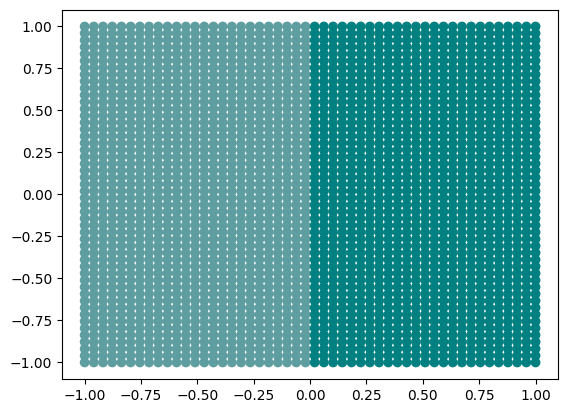

In [196]:
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

#encode_inputs=lambda x: 1 if (abs((x[0]+0.25)**2+x[1]**2-0.25)<0.05 and x[1]<0.1) or (abs((x[0]-0.25)**2+x[1]**2-0.25)<0.05 and x[1]>-0.1) else 0
#encode_inputs=lambda x: 1 if np.random.random()<0.8 else 0
encode_inputs=lambda x: 1 if x[0]<0 else 0
Y=np.array([encode_inputs(x) for x in X])

X=torch.from_numpy(X).float()
Y=torch.from_numpy(Y).float()

colors=np.full(len(Y), 'cadetblue')
colors[Y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [197]:
def next_batch(inputs, targets, batch_size):
    for i in range(0, inputs.shape[0], batch_size):
        yield (inputs[i:i + batch_size], targets[i:i + batch_size])

model = NeuralNet(2,[256,256],2)
ReLU_glorot_init(model)

opt = SGD(model.parameters(), lr=LEARNING_RATE)
lossFunc = nn.CrossEntropyLoss()

def training():
    trainLoss = 0
    samples = 0
    model.train()
    for batchX, batchY in next_batch(X, Y, BATCH_SIZE):
        predictions = model(batchX)
        loss = lossFunc(predictions, batchY.long())
        opt.zero_grad()
        loss.backward()
        opt.step()
        samples += len(batchY)
        trainLoss += loss.item()*len(batchY)
    return trainLoss/samples

def accuracy():
    with torch.no_grad():
        correct=0
        samples=0
        for x,y in next_batch(X,Y,1):
            prediction=torch.argmax(model(x))
            if prediction==y:
                correct+=1
            samples+=1
        return correct/samples


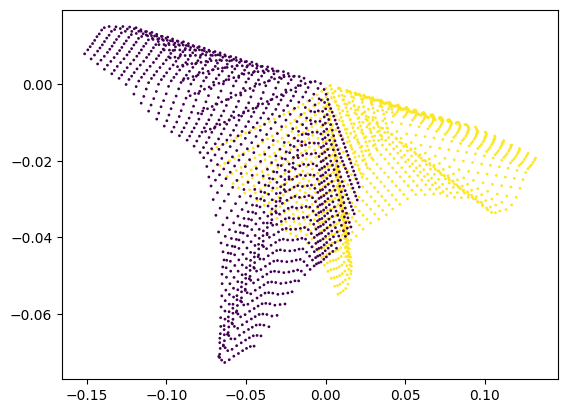

In [198]:
for batchX, batchY in next_batch(X, Y, len(X)):
    outputs=model(batchX).detach().numpy()
plt.scatter(outputs[:,0],outputs[:,1],c=Y,s=1)

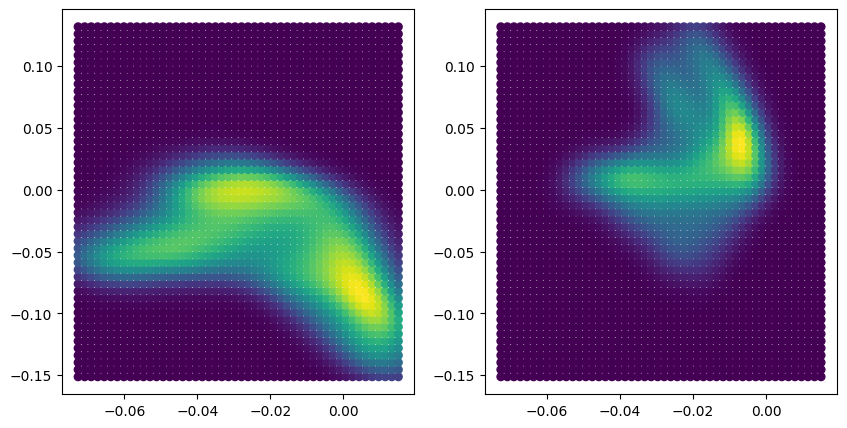

In [199]:
from scipy.stats import gaussian_kde

X1=np.linspace(min(outputs[:,0]),max(outputs[:,0]),RES)
X2=np.linspace(min(outputs[:,1]),max(outputs[:,1]),RES)
plotting_grid=[]
for x1 in X1:
    for x2 in X2:
        plotting_grid.append([x1,x2])
plotting_grid=np.array(plotting_grid)

outputs_one=outputs[Y==1]

density_one=gaussian_kde(outputs_one.T)(plotting_grid.T)
density_one_grid=np.array([density_one[k*RES:(k+1)*RES] for k in range(RES)])

outputs_zero=outputs[Y==0]

density_zero=gaussian_kde(outputs_zero.T)(plotting_grid.T)
density_zero_grid=np.array([density_zero[k*RES:(k+1)*RES] for k in range(RES)])

fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].scatter(plotting_grid[:,1],plotting_grid[:,0],c=density_zero,s=30)
axs[1].scatter(plotting_grid[:,1],plotting_grid[:,0],c=density_one,s=30)

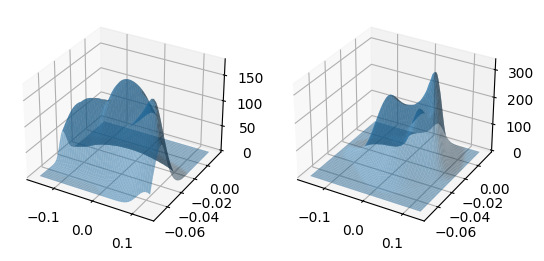

In [200]:
from scipy.stats import gaussian_kde

X1=np.linspace(min(outputs[:,0]),max(outputs[:,0]),RES)
X2=np.linspace(min(outputs[:,1]),max(outputs[:,1]),RES)
plotting_grid=[]
for x1 in X1:
    for x2 in X2:
        plotting_grid.append([x1,x2])
plotting_grid=np.array(plotting_grid)

outputs_one=outputs[Y==1]

density_one=gaussian_kde(outputs_one.T)(plotting_grid.T)
density_one_grid=np.array([density_one[k*RES:(k+1)*RES] for k in range(RES)])

outputs_zero=outputs[Y==0]

density_zero=gaussian_kde(outputs_zero.T)(plotting_grid.T)
density_zero_grid=np.array([density_zero[k*RES:(k+1)*RES] for k in range(RES)])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

xlimits, ylimits = np.meshgrid(X1, X2)
ax.plot_surface(xlimits, ylimits,density_zero_grid,alpha=0.5)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(xlimits, ylimits,density_one_grid,alpha=0.5)

In [201]:
for epoch in range(EPOCHS):
    loss=training()
    print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss))
    if loss<0.01:
        break
acc=accuracy()
print('Accuracy {:.3f}'.format(acc))

Epoch 1: Loss 0.337
Epoch 2: Loss 0.160
Epoch 3: Loss 0.091
Epoch 4: Loss 0.077
Epoch 5: Loss 0.072
Epoch 6: Loss 0.069
Epoch 7: Loss 0.068
Epoch 8: Loss 0.067
Epoch 9: Loss 0.065
Epoch 10: Loss 0.065
Epoch 11: Loss 0.064
Epoch 12: Loss 0.063
Epoch 13: Loss 0.062
Epoch 14: Loss 0.062
Epoch 15: Loss 0.061
Epoch 16: Loss 0.061
Epoch 17: Loss 0.060
Epoch 18: Loss 0.060
Epoch 19: Loss 0.059
Epoch 20: Loss 0.059
Epoch 21: Loss 0.059
Epoch 22: Loss 0.059
Epoch 23: Loss 0.061
Epoch 24: Loss 0.064
Epoch 25: Loss 0.068
Epoch 26: Loss 0.071
Epoch 27: Loss 0.073
Epoch 28: Loss 0.070
Epoch 29: Loss 0.052
Epoch 30: Loss 0.042
Epoch 31: Loss 0.039
Epoch 32: Loss 0.038
Epoch 33: Loss 0.037
Epoch 34: Loss 0.045
Epoch 35: Loss 0.038
Epoch 36: Loss 0.108
Epoch 37: Loss 0.035
Epoch 38: Loss 0.051
Epoch 39: Loss 0.044
Epoch 40: Loss 0.099
Epoch 41: Loss 0.031
Epoch 42: Loss 0.029
Epoch 43: Loss 0.043
Epoch 44: Loss 0.063
Epoch 45: Loss 0.038
Epoch 46: Loss 0.126
Epoch 47: Loss 0.036
Epoch 48: Loss 0.057
E

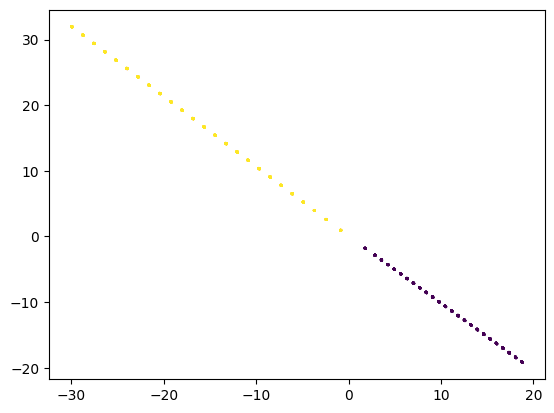

In [202]:
for batchX, batchY in next_batch(X, Y, len(X)):
    outputs=model(batchX).detach().numpy()
plt.scatter(outputs[:,0],outputs[:,1],c=Y,s=1)

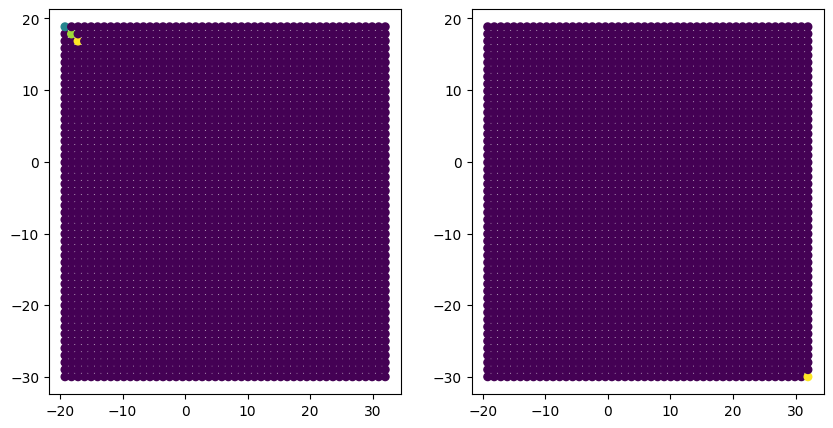

In [203]:
from scipy.stats import gaussian_kde

X1=np.linspace(min(outputs[:,0]),max(outputs[:,0]),RES)
X2=np.linspace(min(outputs[:,1]),max(outputs[:,1]),RES)
plotting_grid=[]
for x1 in X1:
    for x2 in X2:
        plotting_grid.append([x1,x2])
plotting_grid=np.array(plotting_grid)

outputs_one=outputs[Y==1]

density_one=gaussian_kde(outputs_one.T)(plotting_grid.T)
density_one_grid=np.array([density_one[k*RES:(k+1)*RES] for k in range(RES)])

outputs_zero=outputs[Y==0]

density_zero=gaussian_kde(outputs_zero.T)(plotting_grid.T)
density_zero_grid=np.array([density_zero[k*RES:(k+1)*RES] for k in range(RES)])

fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].scatter(plotting_grid[:,1],plotting_grid[:,0],c=density_zero,s=30)
axs[1].scatter(plotting_grid[:,1],plotting_grid[:,0],c=density_one,s=30)

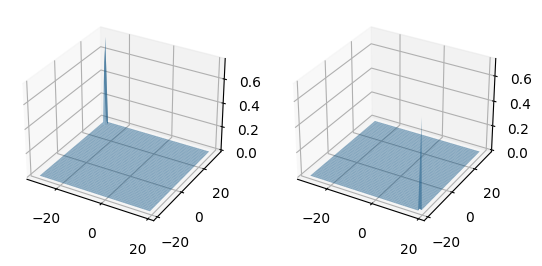

In [205]:
from scipy.stats import gaussian_kde

X1=np.linspace(min(outputs[:,0]),max(outputs[:,0]),RES)
X2=np.linspace(min(outputs[:,1]),max(outputs[:,1]),RES)
plotting_grid=[]
for x1 in X1:
    for x2 in X2:
        plotting_grid.append([x1,x2])
plotting_grid=np.array(plotting_grid)

outputs_one=outputs[Y==1]

density_one=gaussian_kde(outputs_one.T)(plotting_grid.T)
density_one_grid=np.array([density_one[k*RES:(k+1)*RES] for k in range(RES)])

outputs_zero=outputs[Y==0]

density_zero=gaussian_kde(outputs_zero.T)(plotting_grid.T)
density_zero_grid=np.array([density_zero[k*RES:(k+1)*RES] for k in range(RES)])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

xlimits, ylimits = np.meshgrid(X1, X2)
ax.plot_surface(xlimits, ylimits,density_zero_grid,alpha=0.5)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(xlimits, ylimits,density_one_grid,alpha=0.5)